In [1]:
%matplotlib inline
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from coolname import generate_slug as name

In [2]:
inputs = [name(2) for i in range(5)]
hidden = [name(2) for i in range(20)]
done = []
outputs = [name(2) for i in range(5)]
G = nx.DiGraph()

edges = []
    
for h in hidden:
    for _ in range(3):
        edges.append((random.choice(inputs+done),h,random.uniform(0,1)))
        
    for _ in range(1):
        edges.append((h,random.choice(outputs),random.uniform(0,1)))
        
    done.append(h)

G.add_weighted_edges_from(edges)

for n in G:
    G.node[n]['bias'] = random.uniform(0,1)

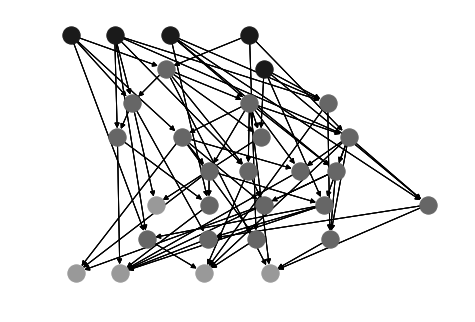

In [3]:
write_dot(G,'test.dot')
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, 
        nodelist=inputs,
        node_color='.1',
        with_labels=False, arrows=True)
nx.draw(G, pos, 
        nodelist=hidden,
        node_color='.4',
        with_labels=False, arrows=True)
nx.draw(G, pos, 
        nodelist=outputs,
        node_color='.6',
        with_labels=False, arrows=True)

In [4]:
def get_layers(G):
    G2 = nx.topological_sort(G)
    max_layer = 0
    for n in G2:
        G.node[n]['layer'] = max([G.node[k[0]]['layer'] for k in G.in_edges(n)] + [-1]) + 1
        max_layer = max(max_layer,G.node[n]['layer'])
    
    layers = [[] for _ in range(max_layer + 1)]
    
    for n in G:
        layers[G.node[n]['layer']].append(n)
    
    flat_idx = 0
    for i, layer in enumerate(layers):
        for j, n in enumerate(layer):
            G.node[n]['idx'] = j
            G.node[n]['flat_idx'] = flat_idx
            flat_idx += 1
            
    return layers

In [5]:
def get_output_idxes(G,outputs):
    out_idxes = []
    for n in G:
        if(n in outputs):
            out_idxes.append(G.node[n]['flat_idx'])
    return out_idxes

In [6]:
layers = get_layers(G)


In [7]:
def graph_to_weights(G, outputs):
    layers = get_layers(G)
    mask = []    
    weights = []
    biases = []
    
    n_nodes = 0
    for i in range(len(layers) - 1):
        n_nodes += len(layers[i])
        mask.append(np.zeros((len(layers[i+1]),n_nodes)))
        biases.append(np.zeros((len(layers[i+1]))))
        weights.append(np.zeros((len(layers[i+1]),n_nodes)))
                      
        for j, node1 in enumerate(layers[i+1]):
            biases[i][j] = G.node[node1]['bias']
            for node0, _ in G.in_edges(node1): 
                u = G.node[node0]['flat_idx']
                v = G.node[node1]['idx']
                mask[i][v,u] = 1
                weights[i][v,u] = G[node0][node1]['weight']
                
    n_nodes += len(layers[-1])
    out_idxes = get_output_idxes(G, outputs)
    lastlayer = np.zeros((len(out_idxes),n_nodes))
    for v, u in enumerate(out_idxes): #identity layer mapping to output neurons
        lastlayer[v,u] = 1
        
    mask.append(lastlayer)
    weights.append(lastlayer)
    biases.append(np.zeros(len(out_idxes)))
                
    return weights, biases, mask
        
        

In [8]:
weights, biases, mask = graph_to_weights(G, outputs)

[print(w) for w in weights]

[[0.78441451 0.25926828 0.         0.         0.        ]
 [0.         0.         0.16431455 0.78717735 0.95881921]]
[[0.63554018 0.         0.55477879 0.         0.         0.61375183
  0.        ]
 [0.         0.         0.         0.77744549 0.         0.44835705
  0.        ]]
[[0.         0.         0.         0.         0.54691223 0.83178332
  0.         0.         0.77214899]
 [0.         0.9841158  0.86331996 0.         0.         0.
  0.         0.         0.58781713]
 [0.57212606 0.         0.         0.         0.         0.
  0.         0.         0.9234117 ]
 [0.         0.         0.22541208 0.         0.         0.21304719
  0.         0.         0.83868101]
 [0.         0.         0.74192909 0.         0.         0.
  0.         0.55564494 0.        ]]
[[0.         0.         0.         0.         0.         0.
  0.         0.09199047 0.         0.34515151 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.87365589 0.         0.
  0.         0. 

[None, None, None, None, None, None, None, None]

In [9]:
def weights_to_graph(weights,biases,G):
    layers = get_layers(G)
    for i in range(len(layers) - 1):
        for j, node1 in enumerate(layers[i+1]):
            G.node[node1]['bias'] = biases[i][j]
            for node0, _ in G.in_edges(node1): 
                u = G.node[node0]['flat_idx']
                v = G.node[node1]['idx']
                G[node0][node1]['weight'] = weights[i][v,u]
    

In [10]:
weights, biases, masks = graph_to_weights(G, outputs)
print(weights[0], biases[0])

weights_to_graph(weights, biases, G)
w2, b2, _ = graph_to_weights(G, outputs)
print(w2[0], biases[0])

[[0.78441451 0.25926828 0.         0.         0.        ]
 [0.         0.         0.16431455 0.78717735 0.95881921]] [0.43443302 0.06088018]
[[0.78441451 0.25926828 0.         0.         0.        ]
 [0.         0.         0.16431455 0.78717735 0.95881921]] [0.43443302 0.06088018]


In [11]:
layer1 = nn.Linear(5,2)

layer1.weight.data = torch.from_numpy(w2[0].astype(np.float32))
layer1.bias.data = torch.from_numpy(b2[0].astype(np.float32))

print(layer1.weight, layer1.bias)

Parameter containing:
tensor([[ 0.7844,  0.2593,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.1643,  0.7872,  0.9588]]) Parameter containing:
tensor([ 0.4344,  0.0609])


In [12]:
print(w2[0].shape)

(2, 5)


In [14]:
class SparseNet(nn.Module):
    def __init__(self, wieghts, biases, masks):
        super(SparseNet, self).__init__()
        self.layers = nn.ModuleList()
        self.masks = masks
        i = 0
        for w, b, m in zip(weights,biases,masks):
            temp = nn.Linear(w.shape[1],w.shape[0])
            temp.weight.data = torch.from_numpy(w.astype(np.float32))
            temp.bias.data = torch.from_numpy(b.astype(np.float32))
            temp.mask = torch.from_numpy(m.astype(np.float32))
            temp.num = i
            temp.register_backward_hook(zero_grad)
            self.layers.append(temp)
            i += 1
        self.layers[-1].requires_grad = False
            
    def forward(self, x):
        for l in self.layers:
            y = l(x)
            x = torch.cat((x,y),1)
            x = F.relu(x)
        return y
    
    def dumpweights(self):
        weights = []
        biases = []
        for l in self.layers:
            weights.append(l.weight.data.numpy().astype(np.float64))
            biases.append(l.bias.data.numpy().astype(np.float64))
        return weights, biases

In [15]:
s = SparseNet(weights,biases,masks)

In [16]:
print(s.layers)

ModuleList(
  (0): Linear(in_features=5, out_features=2, bias=True)
  (1): Linear(in_features=7, out_features=2, bias=True)
  (2): Linear(in_features=9, out_features=5, bias=True)
  (3): Linear(in_features=14, out_features=6, bias=True)
  (4): Linear(in_features=20, out_features=4, bias=True)
  (5): Linear(in_features=24, out_features=4, bias=True)
  (6): Linear(in_features=28, out_features=2, bias=True)
  (7): Linear(in_features=30, out_features=5, bias=True)
)


In [17]:
optimizer = optim.SGD(s.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [23]:
for i in range(100):
    out = s(torch.rand((1,5)))
    optimizer.zero_grad()
    loss = criterion(torch.sum(out),torch.tensor(0.0))
    print(loss)
    loss.backward()
    optimizer.step()

tensor(1.00000e-09 *
       1.3304)
tensor(1.00000e-09 *
       1.0776)
tensor(1.00000e-10 *
       8.7285)
tensor(1.00000e-10 *
       7.0701)
tensor(1.00000e-10 *
       5.7268)
tensor(1.00000e-10 *
       4.6387)
tensor(1.00000e-10 *
       3.7573)
tensor(1.00000e-10 *
       3.0434)
tensor(1.00000e-10 *
       2.4652)
tensor(1.00000e-10 *
       1.9968)
tensor(1.00000e-10 *
       1.6174)
tensor(1.00000e-10 *
       1.3101)
tensor(1.00000e-10 *
       1.0612)
tensor(1.00000e-11 *
       8.5956)
tensor(1.00000e-11 *
       6.9624)
tensor(1.00000e-11 *
       5.6396)
tensor(1.00000e-11 *
       4.5680)
tensor(1.00000e-11 *
       3.7001)
tensor(1.00000e-11 *
       2.9971)
tensor(1.00000e-11 *
       2.4276)
tensor(1.00000e-11 *
       1.9664)
tensor(1.00000e-11 *
       1.5928)
tensor(1.00000e-11 *
       1.2902)
tensor(1.00000e-11 *
       1.0450)
tensor(1.00000e-12 *
       8.4647)
tensor(1.00000e-12 *
       6.8564)
tensor(1.00000e-12 *
       5.5537)
tensor(1.00000e-12 *
       